In [1]:
!pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 15.7 MB/s eta 0:00:00


In [2]:
!pip install transformers

In [2]:
%jupyter nbextension enable --py widgetsnbextension

UsageError: Line magic function `%jupyter` not found.


In [4]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast as BertTokenizer, BertModel, get_linear_schedule_with_warmup
import pytorch_lightning as pl
from torchmetrics.functional.classification import accuracy, auroc, f1_score
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import re

sns.set(style='whitegrid',palette='muted',font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

### Training data

In [22]:
df_train = pd.read_json('annotations/data/subtask1/train.json')
df_train.head()

,id,text,labels,link
0,65635,THIS IS WHY YOU NEED\n\nA SHARPIE WITH YOU AT ...,[Black-and-white Fallacy/Dictatorship],https://www.facebook.com/photo/?fbid=402355213...
1,67927,GOOD NEWS!\n\nNAZANIN ZAGHARI-RATCLIFFE AND AN...,"[Loaded Language, Glittering generalities (Vir...",https://www.facebook.com/amnesty/photos/531198...
2,68031,PAING PHYO MIN IS FREE!,[],https://www.facebook.com/amnesty/photos/427419...
3,77490,Move your ships away!\n\noooook\n\nMove your s...,[],https://www.facebook.com/rightpatriots/photos/...
4,67641,"WHEN YOU'RE THE FBI, THEY LET YOU DO IT.",[Thought-terminating cliché],https://www.facebook.com/AddictingInfoOrg/phot...


In [23]:
df_train['text'] = df_train['text'].str.lower()
df_train['text'] = df_train['text'].str.strip()
df_train['text'] = df_train['text'].str.replace('\\n\\n',' ')
df_train['text'] = df_train['text'].apply(lambda elem: re.sub('[^A-Za-z0-9!?()%-= \']+', '', elem))

In [24]:
df_train.head()

,id,text,labels,link
0,65635,this is why you need a sharpie with you at all...,[Black-and-white Fallacy/Dictatorship],https://www.facebook.com/photo/?fbid=402355213...
1,67927,good news! nazanin zaghari-ratcliffe and anoos...,"[Loaded Language, Glittering generalities (Vir...",https://www.facebook.com/amnesty/photos/531198...
2,68031,paing phyo min is free!,[],https://www.facebook.com/amnesty/photos/427419...
3,77490,move your ships away! oooook move your ships a...,[],https://www.facebook.com/rightpatriots/photos/...
4,67641,"when you're the fbi, they let you do it.",[Thought-terminating cliché],https://www.facebook.com/AddictingInfoOrg/phot...


In [6]:
df_train.shape

(7000, 4)

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      7000 non-null   int64 
 1   text    7000 non-null   object
 2   labels  7000 non-null   object
 3   link    7000 non-null   object
dtypes: int64(1), object(3)
memory usage: 218.9+ KB


In [8]:
labels_train = df_train['labels']
labels_train

0                  [Black-and-white Fallacy/Dictatorship]
1       [Loaded Language, Glittering generalities (Vir...
2                                                      []
3                                                      []
4                            [Thought-terminating cliché]
                              ...                        
6995    [Loaded Language, Causal Oversimplification, T...
6996                      [Loaded Language, Whataboutism]
6997                                                   []
6998                                                   []
6999                                            [Slogans]
Name: labels, Length: 7000, dtype: object

In [9]:
CLASS_NAMES = set()

for category in labels_train:
    category = list(category)
    for label in category:
        CLASS_NAMES.add(label)

CLASS_NAMES

{'Appeal to authority',
 'Appeal to fear/prejudice',
 'Bandwagon',
 'Black-and-white Fallacy/Dictatorship',
 'Causal Oversimplification',
 'Doubt',
 'Exaggeration/Minimisation',
 'Flag-waving',
 'Glittering generalities (Virtue)',
 'Loaded Language',
 "Misrepresentation of Someone's Position (Straw Man)",
 'Name calling/Labeling',
 'Obfuscation, Intentional vagueness, Confusion',
 'Presenting Irrelevant Data (Red Herring)',
 'Reductio ad hitlerum',
 'Repetition',
 'Slogans',
 'Smears',
 'Thought-terminating cliché',
 'Whataboutism'}

In [10]:
len(CLASS_NAMES)

20

In [11]:
for label in CLASS_NAMES:
    df_train.insert(df_train.shape[1],label,[0] * df_train.shape[0],True)
df_train.shape

(7000, 24)

In [12]:
df_train.head()

,id,text,labels,link,Reductio ad hitlerum,Loaded Language,Smears,Thought-terminating cliché,Name calling/Labeling,Glittering generalities (Virtue),...,Whataboutism,Appeal to fear/prejudice,Misrepresentation of Someone's Position (Straw Man),Exaggeration/Minimisation,Black-and-white Fallacy/Dictatorship,Causal Oversimplification,Flag-waving,Repetition,Presenting Irrelevant Data (Red Herring),"Obfuscation, Intentional vagueness, Confusion"
0,65635,this is why you neednna sharpie with you at al...,[Black-and-white Fallacy/Dictatorship],https://www.facebook.com/photo/?fbid=402355213...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,67927,good news!nnnazanin zaghari-ratcliffe and anoo...,"[Loaded Language, Glittering generalities (Vir...",https://www.facebook.com/amnesty/photos/531198...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,68031,paing phyo min is free!,[],https://www.facebook.com/amnesty/photos/427419...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,77490,move your ships away!nnoooooknnmove your ships...,[],https://www.facebook.com/rightpatriots/photos/...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,67641,"when you're the fbi, they let you do it.",[Thought-terminating cliché],https://www.facebook.com/AddictingInfoOrg/phot...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
df_train.columns

Index(['id', 'text', 'labels', 'link', 'Reductio ad hitlerum',
       'Loaded Language', 'Smears', 'Thought-terminating cliché',
       'Name calling/Labeling', 'Glittering generalities (Virtue)', 'Slogans',
       'Doubt', 'Appeal to authority', 'Bandwagon', 'Whataboutism',
       'Appeal to fear/prejudice',
       'Misrepresentation of Someone's Position (Straw Man)',
       'Exaggeration/Minimisation', 'Black-and-white Fallacy/Dictatorship',
       'Causal Oversimplification', 'Flag-waving', 'Repetition',
       'Presenting Irrelevant Data (Red Herring)',
       'Obfuscation, Intentional vagueness, Confusion'],
      dtype='object')

In [14]:
for i in df_train.index:
    labels = list(df_train['labels'][i])
    for label in labels:
        df_train.at[i,label] = 1
df_train.head()

,id,text,labels,link,Reductio ad hitlerum,Loaded Language,Smears,Thought-terminating cliché,Name calling/Labeling,Glittering generalities (Virtue),...,Whataboutism,Appeal to fear/prejudice,Misrepresentation of Someone's Position (Straw Man),Exaggeration/Minimisation,Black-and-white Fallacy/Dictatorship,Causal Oversimplification,Flag-waving,Repetition,Presenting Irrelevant Data (Red Herring),"Obfuscation, Intentional vagueness, Confusion"
0,65635,this is why you neednna sharpie with you at al...,[Black-and-white Fallacy/Dictatorship],https://www.facebook.com/photo/?fbid=402355213...,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,67927,good news!nnnazanin zaghari-ratcliffe and anoo...,"[Loaded Language, Glittering generalities (Vir...",https://www.facebook.com/amnesty/photos/531198...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,68031,paing phyo min is free!,[],https://www.facebook.com/amnesty/photos/427419...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,77490,move your ships away!nnoooooknnmove your ships...,[],https://www.facebook.com/rightpatriots/photos/...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,67641,"when you're the fbi, they let you do it.",[Thought-terminating cliché],https://www.facebook.com/AddictingInfoOrg/phot...,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
df_train['Doubt'].value_counts()

0    6650
1     350
Name: Doubt, dtype: int64

In [16]:
df_train.columns

Index(['id', 'text', 'labels', 'link', 'Reductio ad hitlerum',
       'Loaded Language', 'Smears', 'Thought-terminating cliché',
       'Name calling/Labeling', 'Glittering generalities (Virtue)', 'Slogans',
       'Doubt', 'Appeal to authority', 'Bandwagon', 'Whataboutism',
       'Appeal to fear/prejudice',
       'Misrepresentation of Someone's Position (Straw Man)',
       'Exaggeration/Minimisation', 'Black-and-white Fallacy/Dictatorship',
       'Causal Oversimplification', 'Flag-waving', 'Repetition',
       'Presenting Irrelevant Data (Red Herring)',
       'Obfuscation, Intentional vagueness, Confusion'],
      dtype='object')

In [17]:
column_names = df_train.columns[4:]
dictionary = {}

for label in column_names:
    dictionary[label] = [df_train[label].value_counts()[0], df_train[label].value_counts()[1]]

count_df = pd.DataFrame(dictionary)
count_df.head()

,Reductio ad hitlerum,Loaded Language,Smears,Thought-terminating cliché,Name calling/Labeling,Glittering generalities (Virtue),Slogans,Doubt,Appeal to authority,Bandwagon,Whataboutism,Appeal to fear/prejudice,Misrepresentation of Someone's Position (Straw Man),Exaggeration/Minimisation,Black-and-white Fallacy/Dictatorship,Causal Oversimplification,Flag-waving,Repetition,Presenting Irrelevant Data (Red Herring),"Obfuscation, Intentional vagueness, Confusion"
0,6937,5250,5010,6472,5482,6512,6333,6650,6150,6903,6742,6663,6938,6644,6220,6760,6429,6695,6941,6979
1,63,1750,1990,528,1518,488,667,350,850,97,258,337,62,356,780,240,571,305,59,21


In [18]:
count_df.shape

(2, 20)

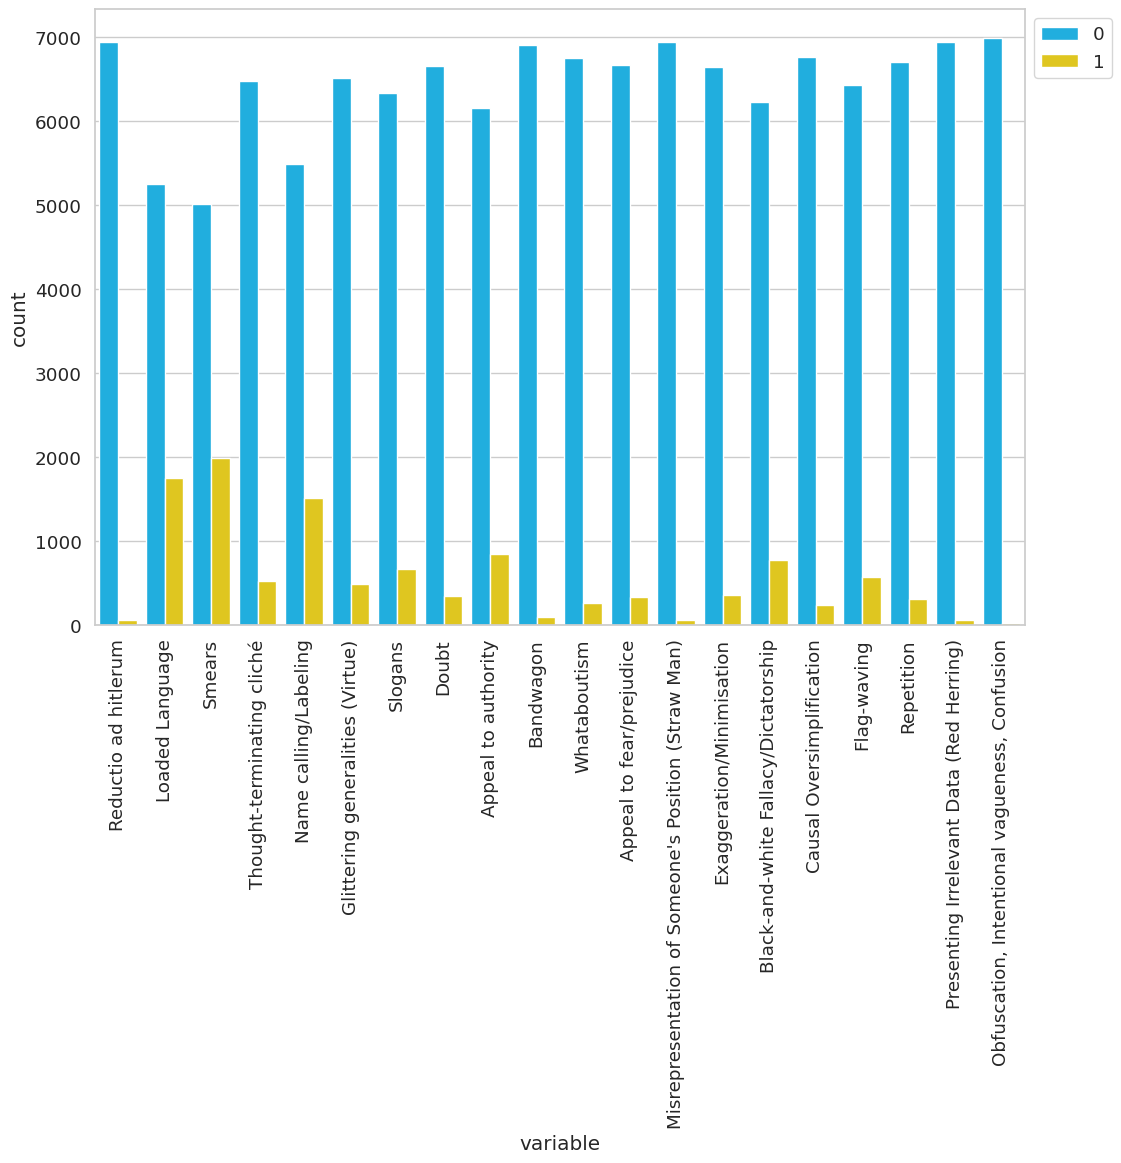

In [19]:
sns.countplot(data=df_train[column_names].melt(),x='variable',hue='value')
plt.legend(bbox_to_anchor=(1,1))
plt.xticks(rotation=90);

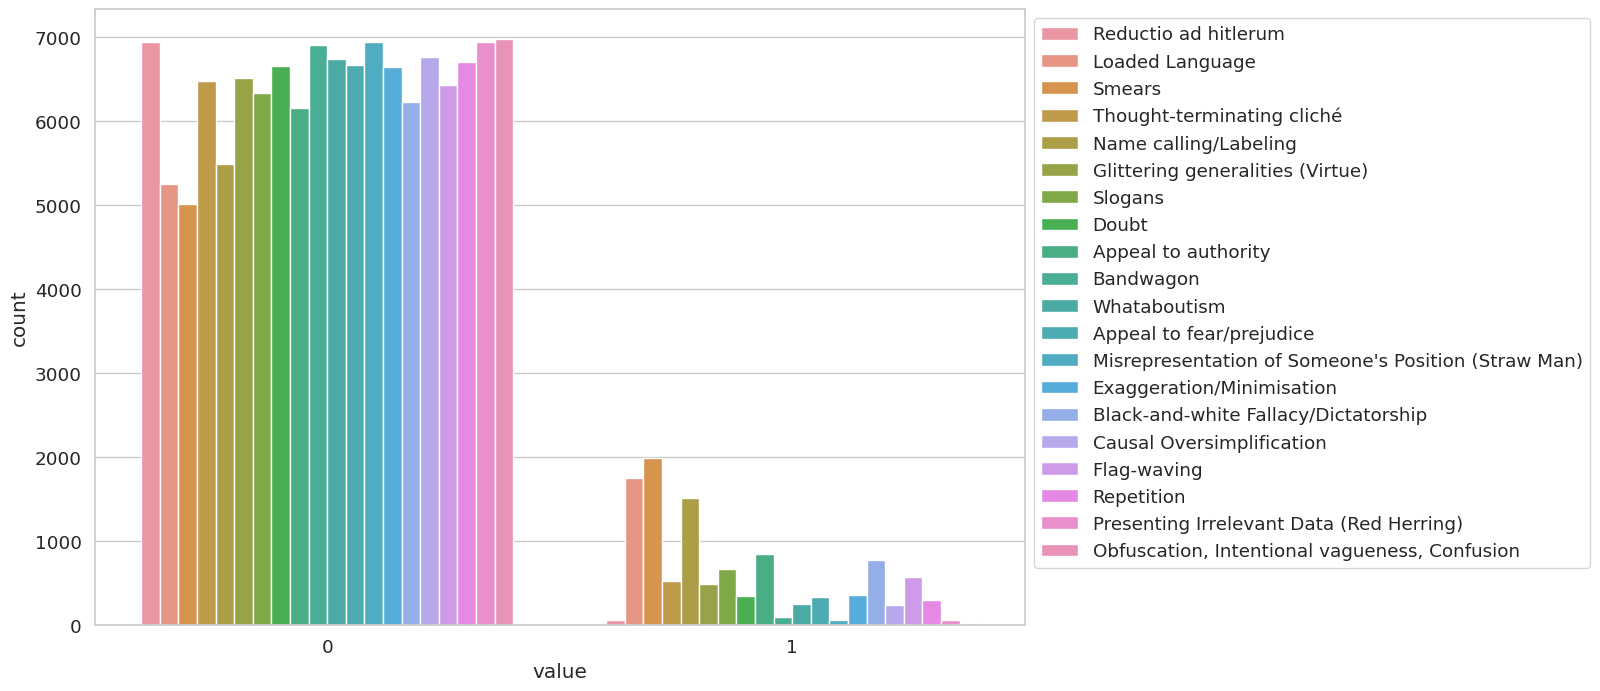

In [20]:
sns.countplot(data=df_train[column_names].melt(),x='value',hue='variable')
plt.legend(bbox_to_anchor=(1,1))

<Axes: >

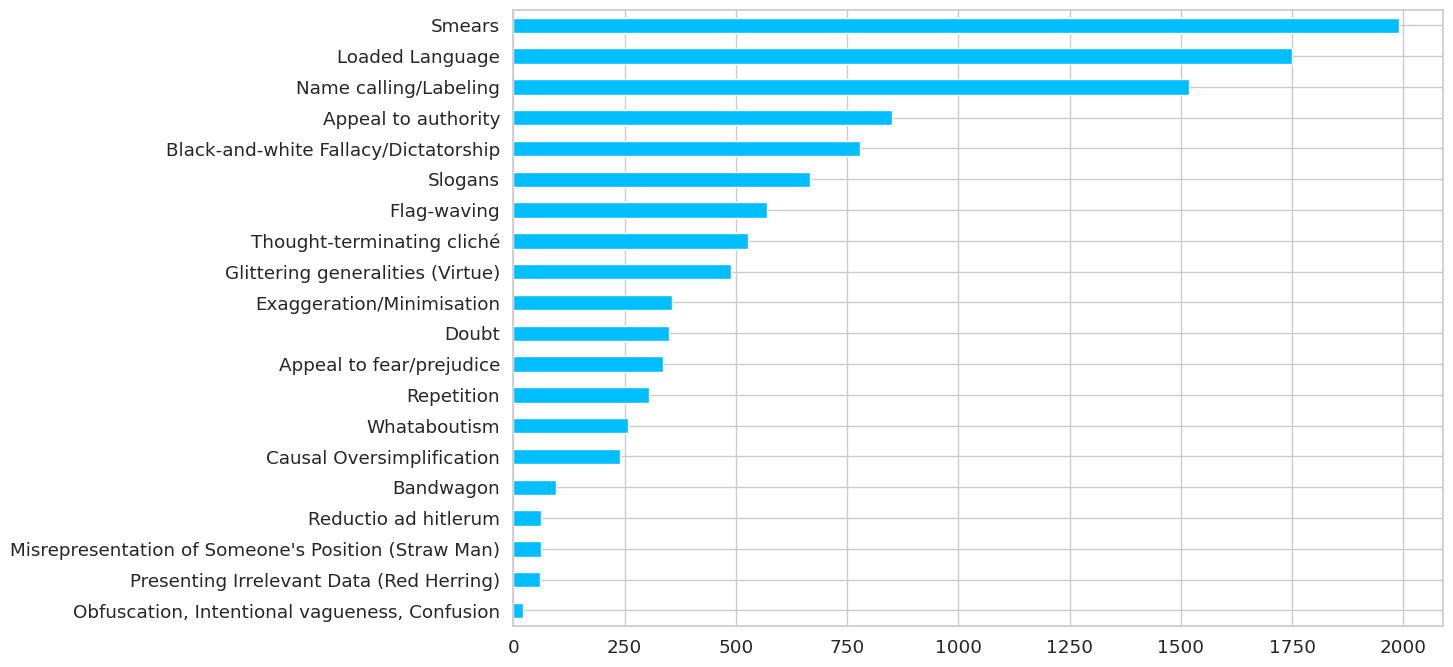

In [21]:
df_train[column_names].sum().sort_values().plot(kind='barh')

### Validation data

In [22]:
df_val = pd.read_json('validation.json')
df_val.head()

,id,text,labels,link
0,63135,Critical Thinking Essentials\n\Are my biases a...,"[Doubt, Slogans]",https://www.facebook.com/SkepticalMemeSociety/...
1,78590,Trying to think of a single accomplishment...,"[Exaggeration/Minimisation, Smears]",https://www.facebook.com/unitedstatesherald/ph...
2,65834,Corporate needs you to find the difference bet...,[Thought-terminating cliché],https://www.facebook.com/photo/?fbid=356249413...
3,67394,KYLE RITTENHOUSE\nALL CHARGES\nNOT GUILTY,[Glittering generalities (Virtue)],https://www.facebook.com/TheControversia/photo...
4,67709,Al Franken explains why America should tax the...,"[Appeal to authority, Slogans, Thought-termina...",https://www.facebook.com/AddictingInfoOrg/phot...


In [23]:
df_val['text'] = df_val['text'].str.lower()
df_val['text'] = df_val['text'].apply(lambda elem: re.sub('[^A-Za-z0-9!?()%-= \']+', '', elem))

In [24]:
df_val.shape

(500, 4)

In [25]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      500 non-null    int64 
 1   text    500 non-null    object
 2   labels  500 non-null    object
 3   link    500 non-null    object
dtypes: int64(1), object(3)
memory usage: 15.8+ KB


In [26]:
labels_val = df_val['labels']
labels_val

0                                       [Doubt, Slogans]
1                    [Exaggeration/Minimisation, Smears]
2                           [Thought-terminating cliché]
3                     [Glittering generalities (Virtue)]
4      [Appeal to authority, Slogans, Thought-termina...
                             ...                        
495         [Slogans, Name calling/Labeling, Repetition]
496                                                   []
497                                                   []
498         [Causal Oversimplification, Loaded Language]
499    [Name calling/Labeling, Appeal to authority, B...
Name: labels, Length: 500, dtype: object

In [27]:
for label in CLASS_NAMES:
    df_val.insert(df_val.shape[1],label,[0] * df_val.shape[0],True)
df_val.shape

(500, 24)

In [28]:
df_val.head()

,id,text,labels,link,Reductio ad hitlerum,Loaded Language,Smears,Thought-terminating cliché,Name calling/Labeling,Glittering generalities (Virtue),...,Whataboutism,Appeal to fear/prejudice,Misrepresentation of Someone's Position (Straw Man),Exaggeration/Minimisation,Black-and-white Fallacy/Dictatorship,Causal Oversimplification,Flag-waving,Repetition,Presenting Irrelevant Data (Red Herring),"Obfuscation, Intentional vagueness, Confusion"
0,63135,critical thinking essentialsnare my biases aff...,"[Doubt, Slogans]",https://www.facebook.com/SkepticalMemeSociety/...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,78590,trying to think of a single accomplishment...,"[Exaggeration/Minimisation, Smears]",https://www.facebook.com/unitedstatesherald/ph...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,65834,corporate needs you to find the difference bet...,[Thought-terminating cliché],https://www.facebook.com/photo/?fbid=356249413...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,67394,kyle rittenhousenall chargesnnot guilty,[Glittering generalities (Virtue)],https://www.facebook.com/TheControversia/photo...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,67709,al franken explains why america should tax the...,"[Appeal to authority, Slogans, Thought-termina...",https://www.facebook.com/AddictingInfoOrg/phot...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
df_val.columns

Index(['id', 'text', 'labels', 'link', 'Reductio ad hitlerum',
       'Loaded Language', 'Smears', 'Thought-terminating cliché',
       'Name calling/Labeling', 'Glittering generalities (Virtue)', 'Slogans',
       'Doubt', 'Appeal to authority', 'Bandwagon', 'Whataboutism',
       'Appeal to fear/prejudice',
       'Misrepresentation of Someone's Position (Straw Man)',
       'Exaggeration/Minimisation', 'Black-and-white Fallacy/Dictatorship',
       'Causal Oversimplification', 'Flag-waving', 'Repetition',
       'Presenting Irrelevant Data (Red Herring)',
       'Obfuscation, Intentional vagueness, Confusion'],
      dtype='object')

In [30]:
for i in df_val.index:
    labels = list(df_val['labels'][i])
    for label in labels:
        df_val.at[i,label] = 1
df_val.head()

,id,text,labels,link,Reductio ad hitlerum,Loaded Language,Smears,Thought-terminating cliché,Name calling/Labeling,Glittering generalities (Virtue),...,Whataboutism,Appeal to fear/prejudice,Misrepresentation of Someone's Position (Straw Man),Exaggeration/Minimisation,Black-and-white Fallacy/Dictatorship,Causal Oversimplification,Flag-waving,Repetition,Presenting Irrelevant Data (Red Herring),"Obfuscation, Intentional vagueness, Confusion"
0,63135,critical thinking essentialsnare my biases aff...,"[Doubt, Slogans]",https://www.facebook.com/SkepticalMemeSociety/...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,78590,trying to think of a single accomplishment...,"[Exaggeration/Minimisation, Smears]",https://www.facebook.com/unitedstatesherald/ph...,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,65834,corporate needs you to find the difference bet...,[Thought-terminating cliché],https://www.facebook.com/photo/?fbid=356249413...,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,67394,kyle rittenhousenall chargesnnot guilty,[Glittering generalities (Virtue)],https://www.facebook.com/TheControversia/photo...,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,67709,al franken explains why america should tax the...,"[Appeal to authority, Slogans, Thought-termina...",https://www.facebook.com/AddictingInfoOrg/phot...,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


<Axes: >

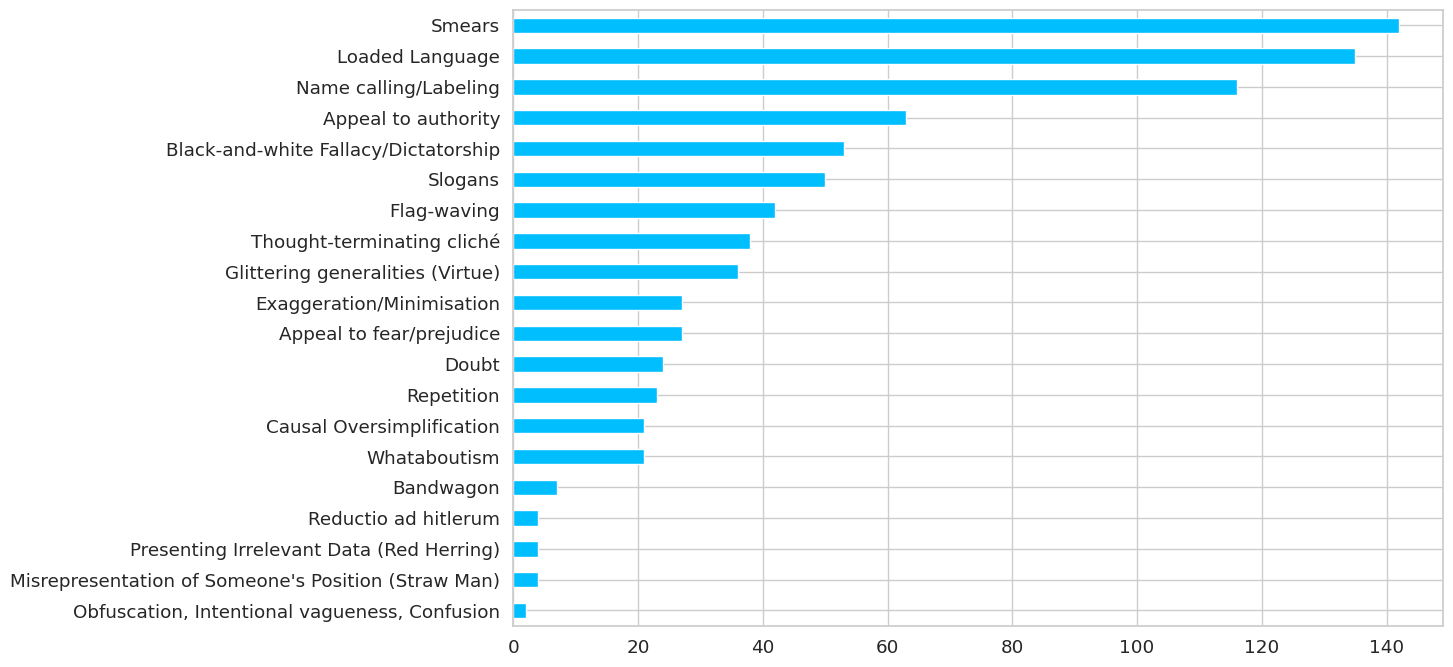

In [31]:
df_val[column_names].sum().sort_values().plot(kind='barh')

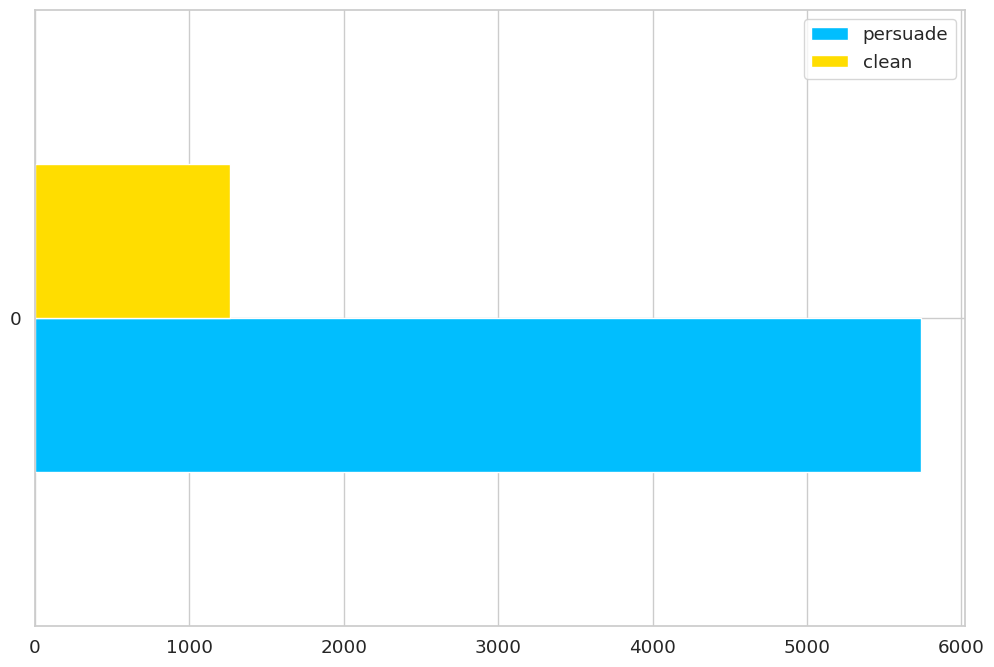

In [32]:
train_persuade = df_train[df_train[column_names].sum(axis=1) > 0]
train_clean = df_train[df_train[column_names].sum(axis=1) == 0]
pd.DataFrame(dict(
  persuade=[len(train_persuade)],
  clean=[len(train_clean)]
)).plot(kind='barh');

In [33]:
train_persuade.shape, train_clean.shape

((5736, 24), (1264, 24))

### Sample testing

In [34]:
df_train = df_train.drop(columns=['id','labels','link'],axis=1)
df_val = df_val.drop(columns=['id','labels','link'])

df_train.shape, df_val.shape

((7000, 21), (500, 21))

In [35]:
CLASS_NAMES

{'Appeal to authority',
 'Appeal to fear/prejudice',
 'Bandwagon',
 'Black-and-white Fallacy/Dictatorship',
 'Causal Oversimplification',
 'Doubt',
 'Exaggeration/Minimisation',
 'Flag-waving',
 'Glittering generalities (Virtue)',
 'Loaded Language',
 "Misrepresentation of Someone's Position (Straw Man)",
 'Name calling/Labeling',
 'Obfuscation, Intentional vagueness, Confusion',
 'Presenting Irrelevant Data (Red Herring)',
 'Reductio ad hitlerum',
 'Repetition',
 'Slogans',
 'Smears',
 'Thought-terminating cliché',
 'Whataboutism'}

In [36]:
LABEL_COLUMNS = list(CLASS_NAMES)
sample_row = df_train.iloc[16]
sample_text = sample_row.text
sample_label = sample_row[LABEL_COLUMNS]

print(sample_text,end='\n\n')
print(sample_label.to_dict())

me voting anti-trump in 2016nnme voting anti-trump in 2020

{'Reductio ad hitlerum': 0, 'Loaded Language': 0, 'Smears': 0, 'Thought-terminating cliché': 0, 'Name calling/Labeling': 0, 'Glittering generalities (Virtue)': 0, 'Slogans': 0, 'Doubt': 0, 'Appeal to authority': 0, 'Bandwagon': 0, 'Whataboutism': 0, 'Appeal to fear/prejudice': 0, "Misrepresentation of Someone's Position (Straw Man)": 0, 'Exaggeration/Minimisation': 0, 'Black-and-white Fallacy/Dictatorship': 0, 'Causal Oversimplification': 0, 'Flag-waving': 0, 'Repetition': 1, 'Presenting Irrelevant Data (Red Herring)': 0, 'Obfuscation, Intentional vagueness, Confusion': 0}


In [37]:
LABEL_COLUMNS, len(LABEL_COLUMNS)

(['Reductio ad hitlerum',
  'Loaded Language',
  'Smears',
  'Thought-terminating cliché',
  'Name calling/Labeling',
  'Glittering generalities (Virtue)',
  'Slogans',
  'Doubt',
  'Appeal to authority',
  'Bandwagon',
  'Whataboutism',
  'Appeal to fear/prejudice',
  "Misrepresentation of Someone's Position (Straw Man)",
  'Exaggeration/Minimisation',
  'Black-and-white Fallacy/Dictatorship',
  'Causal Oversimplification',
  'Flag-waving',
  'Repetition',
  'Presenting Irrelevant Data (Red Herring)',
  'Obfuscation, Intentional vagueness, Confusion'],
 20)

In [38]:
BERT_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)
tokenizer

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

BertTokenizerFast(name_or_path='bert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [39]:
encoding = tokenizer.encode_plus(sample_text,
                      add_special_tokens=True,
                      max_length=512,
                      return_token_type_ids=False,
                      padding='max_length',
                      return_attention_mask=True,
                      return_tensors='pt')
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [40]:
encoding['input_ids'].shape, encoding['attention_mask'].shape

(torch.Size([1, 512]), torch.Size([1, 512]))

In [41]:
encoding['input_ids'].squeeze()[:40]

tensor([  101,  1143,  6612,  2848,   118,   189, 27321,  1107,  1446,  9238,
         3263,  6612,  2848,   118,   189, 27321,  1107, 12795,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])

In [42]:
encoding['attention_mask'].squeeze()[:40]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [43]:
encoding['input_ids'].squeeze().shape

torch.Size([512])

In [44]:
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'].squeeze())[:20])

['[CLS]', 'me', 'voting', 'anti', '-', 't', '##rump', 'in', '2016', '##nn', '##me', 'voting', 'anti', '-', 't', '##rump', 'in', '2020', '[SEP]', '[PAD]']


(0.0, 512.0)

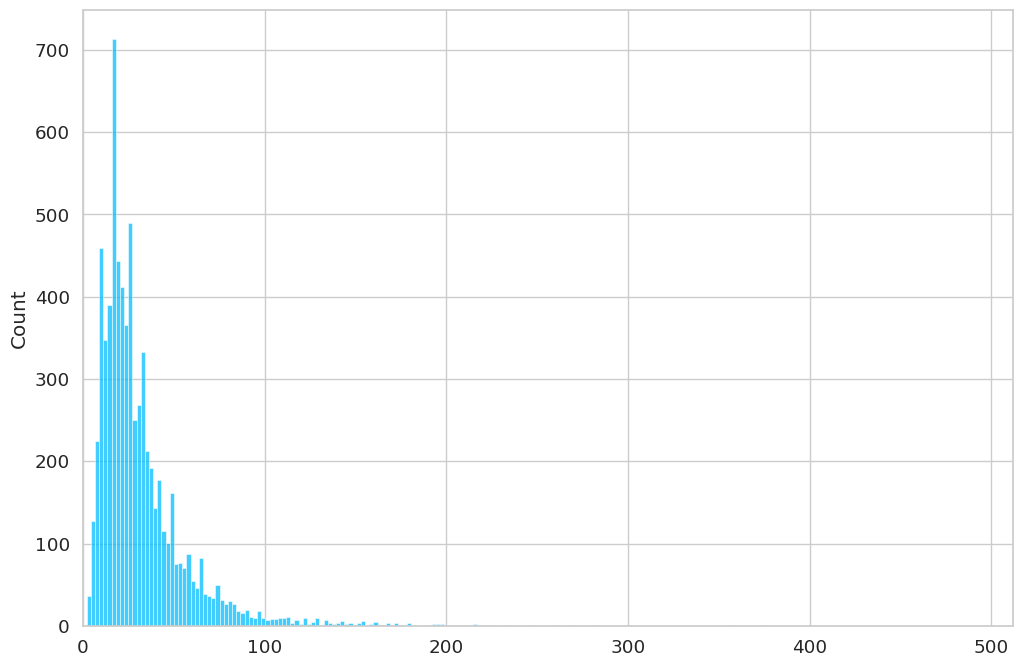

In [45]:
token_counts = []

for _, row in df_train.iterrows():
    token_count = len(tokenizer.encode(
        row['text'],
        max_length=512,
        truncation=True
    ))
    token_counts.append(token_count)

sns.histplot(token_counts)
plt.xlim([0,512])

In [46]:
MAX_TOKEN_COUNT = 256

### Special Tokens

In [47]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [48]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [49]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [50]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

### Creating the Dataset & Loading the model

In [51]:
class PersuasionDataset(Dataset):
    def __init__(self,
                 data: pd.DataFrame,
                 tokenizer: BertTokenizer,
                 max_token_len: int = 128):
        self.data=data
        self.tokenizer=tokenizer
        self.max_token_len=max_token_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]
        meme_text = data_row.text
        labels = data_row[LABEL_COLUMNS]

        encoding = self.tokenizer.encode_plus(
            meme_text,
            add_special_tokens=True,
            max_length=self.max_token_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return dict(
            meme_text=meme_text,
            input_ids=encoding['input_ids'].flatten(),
            attention_mask=encoding['attention_mask'].flatten(),
            labels=torch.FloatTensor(labels)
        )

In [52]:
train_dataset = PersuasionDataset(df_train,tokenizer,MAX_TOKEN_COUNT)
train_dataset

In [53]:
sample_item = train_dataset[0]
sample_item.keys()

dict_keys(['meme_text', 'input_ids', 'attention_mask', 'labels'])

In [54]:
sample_item['meme_text']

'this is why you neednna sharpie with you at all times'

In [55]:
sample_item['labels'], sample_item['labels'].shape

(tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0.]),
 torch.Size([20]))

In [56]:
sample_item['input_ids'].shape

torch.Size([256])

In [57]:
bert_model = BertModel.from_pretrained(BERT_MODEL_NAME,return_dict=True)
bert_model

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [58]:
sample_item['input_ids'].unsqueeze(dim=0).shape

torch.Size([1, 256])

In [59]:
prediction = bert_model(sample_item['input_ids'].unsqueeze(dim=0),
                        sample_item['attention_mask'].unsqueeze(dim=0))

prediction.last_hidden_state.shape, prediction.pooler_output.shape

(torch.Size([1, 256, 768]), torch.Size([1, 768]))

In [60]:
sample_batch = next(iter(DataLoader(train_dataset, batch_size=8)))

sample_batch["input_ids"].shape, sample_batch["attention_mask"].shape

(torch.Size([8, 256]), torch.Size([8, 256]))

In [61]:
output = bert_model(sample_batch["input_ids"], sample_batch["attention_mask"])

output.last_hidden_state.shape, output.pooler_output.shape

(torch.Size([8, 256, 768]), torch.Size([8, 768]))

### Creating the Data Module

In [62]:
class PersuasionDataModule(pl.LightningDataModule):
    def __init__(self,train_df,test_df,tokenizer,batch_size=8,max_token_len=128):
        super().__init__()
        self.train_df=train_df
        self.test_df=test_df
        self.tokenizer=tokenizer
        self.batch_size=batch_size
        self.max_token_len=max_token_len

    def setup(self,stage=None):
        self.train_dataset = PersuasionDataset(
            self.train_df,
            self.tokenizer,
            self.max_token_len
        )

        self.test_dataset = PersuasionDataset(
            self.test_df,
            self.tokenizer,
            self.max_token_len
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
        )

In [63]:
EPOCHS = 6
BATCH_SIZE = 12

data_module = PersuasionDataModule(df_train,df_val,tokenizer,BATCH_SIZE,MAX_TOKEN_COUNT)
data_module

In [64]:
class PersuasionTechniqueDetector(pl.LightningModule):
    def __init__(self,n_classes: int,n_training_steps=None,n_warmup_steps=None):
        super().__init__()
        self.bert = BertModel.from_pretrained(BERT_MODEL_NAME,return_dict=True)
        self.classifier = nn.Linear(self.bert.config.hidden_size,n_classes)
        self.n_training_steps = n_training_steps
        self.n_warmup_steps = n_warmup_steps
        self.criterion = nn.BCELoss()
        self.outputs = []

    def forward(self,input_ids,attention_mask,labels=None):
        output = self.bert(input_ids,attention_mask=attention_mask)
        output = self.classifier(output.pooler_output)
        output = torch.sigmoid(output)
        loss = 0

        if labels is not None:
            loss = self.criterion(output,labels)

        return loss, output

    def training_step(self,batch):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        loss, output = self(input_ids,attention_mask,labels)
        self.log('train_loss',loss,prog_bar=True,logger=True)
        output_dict = {
            'loss': loss,
            'predictions': output,
            'labels': labels
        }
        self.outputs.append(output_dict)

        return output_dict

    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("val_loss", loss, prog_bar=True, logger=True)

        return loss

    def test_step(self,batch):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        loss, output = self(input_ids,attention_mask,labels)
        self.log('test_loss',loss,prog_bar=True,logger=True)

        return loss

    def on_train_epoch_end(self):
        labels = []
        predictions = []

        for output in self.outputs:
            for out_labels in output['labels'].detach().cpu():
                labels.append(out_labels)
            for out_predictions in output['predictions'].detach().cpu():
                predictions.append(out_predictions)
        self.outputs.clear()

        labels = torch.stack(labels).int()
        predictions = torch.stack(predictions)

        for i, name in enumerate(LABEL_COLUMNS):
            class_roc_auc = auroc(predictions[:,i].unsqueeze(dim=0),labels[:,i].unsqueeze(dim=0),task='multilabel',num_labels=7000)
            self.logger.experiment.add_scalar(f'{name}_roc_auc/Train',class_roc_auc,self.current_epoch)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(),lr=2e-5)
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=self.n_warmup_steps,
            num_training_steps=self.n_training_steps
        )

        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'step'
            }
        }

### Optimizer Scheduler

In [65]:
test_model = nn.Linear(in_features=2,out_features=1)
optimizer = torch.optim.AdamW(params=test_model.parameters(),lr=0.001)

warmup_steps = 20
total_training_steps = 100

scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_training_steps
)

learning_rate_history = []

for step in range(total_training_steps):
    optimizer.step()
    scheduler.step()
    learning_rate_history.append(optimizer.param_groups[0]['lr'])

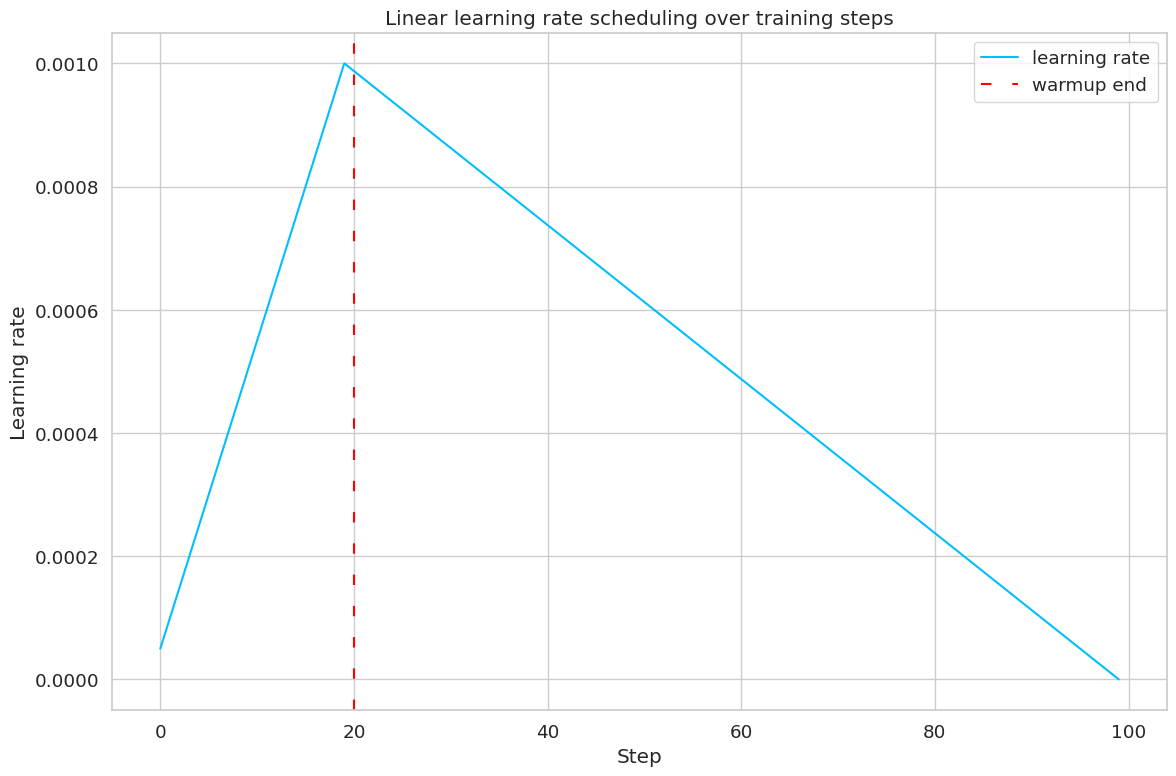

In [66]:
plt.plot(learning_rate_history,label='learning rate')
plt.axvline(x=warmup_steps,color='red',linestyle=(0,(5,10)),label='warmup end')
plt.legend()
plt.title('Linear learning rate scheduling over training steps')
plt.xlabel('Step')
plt.ylabel('Learning rate')
plt.tight_layout();

In [67]:
steps_per_epoch = len(df_train) // BATCH_SIZE
total_training_steps = steps_per_epoch * EPOCHS
warmup_steps = total_training_steps // 5

steps_per_epoch, total_training_steps, warmup_steps

(583, 3498, 699)

In [68]:
model = PersuasionTechniqueDetector(
    n_classes=len(CLASS_NAMES),
    n_warmup_steps=warmup_steps,
    n_training_steps=total_training_steps
)

model

PersuasionTechniqueDetector(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

### Base Model Evaluation

In [69]:
loss = nn.BCELoss()

prediction = torch.FloatTensor(
    [10.95873564, 1.07321467, 1.58524066, 0.03839076, 15.72987556, 1.09513213]
)

labels = torch.FloatTensor(
    [1., 0., 0., 0., 1., 0.]
)

In [70]:
torch.sigmoid(prediction)

tensor([1.0000, 0.7452, 0.8299, 0.5096, 1.0000, 0.7493])

In [71]:
loss(torch.sigmoid(prediction),labels)

tensor(0.8725)

In [72]:
_, predictions = model(sample_item['input_ids'].unsqueeze(dim=0),sample_item['attention_mask'].unsqueeze(dim=0))
predictions

tensor([[0.5441, 0.5106, 0.3701, 0.3723, 0.4927, 0.5022, 0.4150, 0.4253, 0.4559,
         0.3750, 0.4026, 0.3841, 0.6029, 0.6327, 0.5287, 0.5565, 0.5697, 0.3637,
         0.5479, 0.5262]], grad_fn=<SigmoidBackward0>)

In [73]:
loss(predictions,sample_item['labels'].unsqueeze(dim=0))

tensor(0.6592, grad_fn=<BinaryCrossEntropyBackward0>)

### ROC Curve

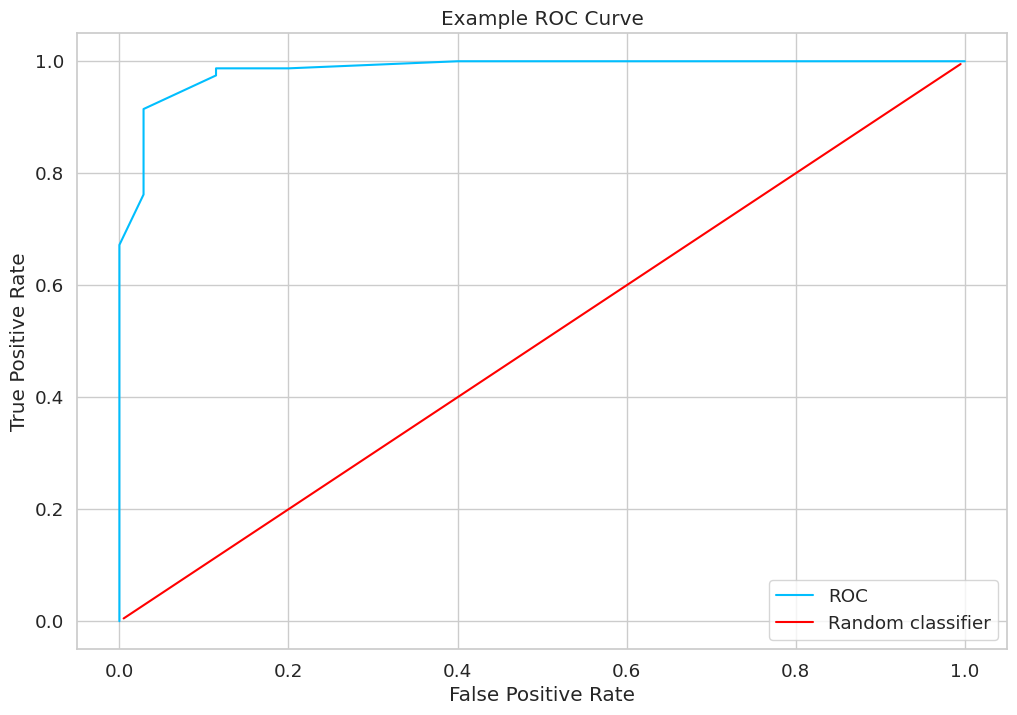

In [74]:
fpr = [0.        , 0.        , 0.        , 0.02857143, 0.02857143,
       0.11428571, 0.11428571, 0.2       , 0.4       , 1.        ]

tpr = [0.        , 0.01265823, 0.67202532, 0.76202532, 0.91468354,
       0.97468354, 0.98734177, 0.98734177, 1.        , 1.        ]

_, ax = plt.subplots()
ax.plot(fpr,tpr,label='ROC')
ax.plot([0.05,0.95],[0.05,0.95],transform=ax.transAxes,label='Random classifier',color='red')
ax.legend(loc=4)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Example ROC Curve')
plt.show();

### Training the model

In [75]:
checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints',
    filename='best-checkpoint',
    save_top_k=1,
    verbose=True,
    monitor='val_loss',
    mode='min'
)

In [76]:
logger = TensorBoardLogger('lightning_logs',name='persuasion_techniques')

In [77]:
early_stopping_callback = EarlyStopping(monitor='val_loss',patience=2)

In [78]:
trainer = pl.Trainer(
    logger=logger,
    callbacks=[early_stopping_callback,checkpoint_callback],
    max_epochs=EPOCHS,
    devices='auto',
    accelerator='auto',
    enable_progress_bar=True
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [79]:
trainer.fit(model,data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 108 M 
1 | classifier | Linear    | 15.4 K
2 | criterion  | BCELoss   | 0     
-----------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.303   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 584: 'val_loss' reached 0.24346 (best 0.24346), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 1168: 'val_loss' reached 0.21962 (best 0.21962), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 1752: 'val_loss' reached 0.20736 (best 0.20736), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 2336: 'val_loss' reached 0.20432 (best 0.20432), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 2920: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 3504: 'val_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=6` reached.


In [80]:
import pickle

with open('bert_model_v2.pkl', 'wb') as f:
    pickle.dump(model, f)
print('model saved')

model saved


In [210]:
import pickle

trained_model = PersuasionTechniqueDetector(
    n_classes=len(CLASS_NAMES),
    n_warmup_steps=warmup_steps,
    n_training_steps=total_training_steps
)
print('Loading model parameters...')
with open('bert_model_v2.pkl','rb') as f:
    trained_model = pickle.load(f)
print('Loaded successfully!')

Loading model parameters...
Loaded successfully!


In [211]:
trained_model.eval()
trained_model.freeze()

In [212]:
test_meme_text = "WE WILL LEAVE THE COUNTRY IF TRUMP IS ELECTED\\n\\nPLEASE LIKE AND SHARE TO SUPPORT THEIR PLAN!"
test_meme_text = test_meme_text.lower()
test_meme_text = re.sub('[^A-Za-z0-9!?()%-= \']+', '', test_meme_text)

encoding = tokenizer.encode_plus(
    test_meme_text,
    add_special_tokens=True,
    max_length=MAX_TOKEN_COUNT,
    return_token_type_ids=False,
    padding='max_length',
    return_attention_mask=True,
    return_tensors='pt'
)

_, test_prediction = trained_model(encoding['input_ids'],encoding['attention_mask'])
test_prediction = test_prediction.flatten().numpy()

for label, prediction in zip(CLASS_NAMES, test_prediction):
  print(f"{label}: {prediction}")

Reductio ad hitlerum: 0.014778407290577888
Loaded Language: 0.05393657460808754
Smears: 0.09679171442985535
Thought-terminating cliché: 0.029711557552218437
Name calling/Labeling: 0.026722989976406097
Glittering generalities (Virtue): 0.3056359589099884
Slogans: 0.1008310541510582
Doubt: 0.03661143034696579
Appeal to authority: 0.006629724986851215
Bandwagon: 0.04045678302645683
Whataboutism: 0.033010825514793396
Appeal to fear/prejudice: 0.04107464849948883
Misrepresentation of Someone's Position (Straw Man): 0.018924914300441742
Exaggeration/Minimisation: 0.07353796809911728
Black-and-white Fallacy/Dictatorship: 0.18058651685714722
Causal Oversimplification: 0.030521243810653687
Flag-waving: 0.25189974904060364
Repetition: 0.011517362669110298
Presenting Irrelevant Data (Red Herring): 0.010733355768024921
Obfuscation, Intentional vagueness, Confusion: 0.010335773229598999


In [213]:
THRESHOLD = 0.2

test_meme_text = "WE WILL LEAVE THE COUNTRY IF TRUMP IS ELECTED\\n\\nPLEASE LIKE AND SHARE TO SUPPORT THEIR PLAN!"
test_meme_text = test_meme_text.lower()
test_meme_text = re.sub('[^A-Za-z0-9!?()%-= \']+', '', test_meme_text)

encoding = tokenizer.encode_plus(
    test_meme_text,
    add_special_tokens=True,
    max_length=MAX_TOKEN_COUNT,
    return_token_type_ids=False,
    padding='max_length',
    return_attention_mask=True,
    return_tensors='pt'
)

_, test_prediction = trained_model(encoding['input_ids'],encoding['attention_mask'])
test_prediction = test_prediction.flatten().numpy()

for label, prediction in zip(CLASS_NAMES, test_prediction):
    if prediction < THRESHOLD:
        continue
    print(f"{label}: {prediction}")

Glittering generalities (Virtue): 0.3056359589099884
Flag-waving: 0.25189974904060364


In [214]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)

predictions = []
labels = []

for item in tqdm(train_dataset):
  _, prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device),
    item["attention_mask"].unsqueeze(dim=0).to(device)
  )

  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

  0%|          | 0/7000 [00:00<?, ?it/s]

In [215]:
accuracy(predictions, labels, threshold=THRESHOLD, task='multilabel', num_labels=len(column_names))

tensor(0.9565)

In [216]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)
val_dataset = PersuasionDataset(
  df_val,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

predictions = []
labels = []

for item in tqdm(val_dataset):
  _, prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device),
    item["attention_mask"].unsqueeze(dim=0).to(device)
  )

  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

  0%|          | 0/500 [00:00<?, ?it/s]

In [217]:
accuracy(predictions, labels, threshold=THRESHOLD, task='multilabel', num_labels=len(column_names))

tensor(0.9137)

In [218]:
from sklearn.metrics import classification_report

y_pred = predictions.numpy()
y_true = labels.numpy()
upper, lower = 1, 0
y_pred = np.where(y_pred > THRESHOLD, upper, lower)
print(classification_report(
  y_true,
  y_pred,
  target_names=LABEL_COLUMNS,
  zero_division=0
))

                                                     precision    recall  f1-score   support

                               Reductio ad hitlerum       0.00      0.00      0.00         4
                                    Loaded Language       0.48      0.64      0.54       135
                                             Smears       0.49      0.70      0.57       142
                         Thought-terminating cliché       0.26      0.24      0.25        38
                              Name calling/Labeling       0.58      0.72      0.64       116
                   Glittering generalities (Virtue)       0.39      0.31      0.34        36
                                            Slogans       0.37      0.40      0.38        50
                                              Doubt       0.22      0.08      0.12        24
                                Appeal to authority       0.77      0.81      0.79        63
                                          Bandwagon       0.00      0